# Table of Contents
- Importing libraries
- Plot Settings
- Reading and preprocessing the data
- Statistical Normality test
- Timeseries Analysis
- Checking Stationarity in Timeseries data
- Recurrent Neural Networks : LSTM & GRU
- Comparison : LSTM vs GRU    

# Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import warnings
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings('ignore')

# Plot Settings

In [2]:

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 23
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['figure.figsize'] = 10,7
sns.set_style('ticks')

# Reading and preprocessing the data

In [3]:
csv_file='household_power_consumption.txt'
df=pd.read_csv(csv_file, delimiter=';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df['Datetime'] =pd.to_datetime(df['Date'] + ' ' + df['Time']) 
df.drop(['Date','Time'],axis=1,inplace=True)

Total length : 2075259


Text(0, 0.5, '% Missing values')

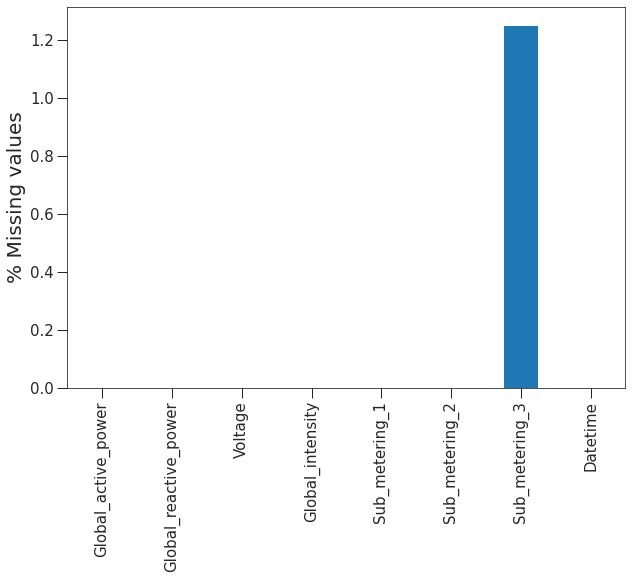

In [5]:
print(f'Total length : {len(df)}')
missing_values= df.isnull().sum()*100 / len(df)
missing_values.plot.bar()
plt.ylabel('% Missing values')

In [6]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce') ## Removes invalid entries with NaN
df.dropna(subset=['Global_active_power'],inplace=True)
df['year'] = df['Datetime'].apply(lambda x: x.year)
df['quarter'] = df['Datetime'].apply(lambda x: x.quarter)
df['month'] = df['Datetime'].apply(lambda x: x.month)
df['day'] = df['Datetime'].apply(lambda x: x.day)

In [7]:
df=df.loc[:,['Datetime','Global_active_power', 'year','quarter','month','day']]
df.index = df['Datetime']
df=df.sort_index(ascending=True)
df['weekday']=df['Datetime'].map(lambda x: x.weekday())
df['weekday'] = (df['weekday'] < 5).astype(int)

In [8]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.Datetime.min())
print('The time series ends on: ', df.Datetime.max())

Number of rows and columns after removing missing values: (2049280, 7)
The time series starts from:  2006-12-16 17:24:00
The time series ends on:  2010-12-11 23:59:00


In [9]:
df.loc[:,'Global_active_power'].T.describe().round(3)

count    2049280.000
mean           1.092
std            1.057
min            0.076
25%            0.308
50%            0.602
75%            1.528
max           11.122
Name: Global_active_power, dtype: float64

After the missing values are removed, the final data set comprises 2049280 measurements collected between December 2006 and November 2010. (47 months). <br>
The initial data contains several variables. We will here focus on a single value : a house's `Global_active_power` history, that is, household global minute-averaged active power in kilowatt.

# Statistical Normality Test
There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution.In the SciPy implementation of the test, the data can be interpretted using the p value as follows.
- p <= alpha: reject , not normal.
- p > alpha: fail to reject H0, normal.<br>
This means that, in general, a larger p-value to confirms that our sample was likely drawn from a Gaussian distribution.

A result above 5% does not mean that the null hypothesis is true. It means that it is very likely true given available evidence.

## Hypothesis testing with Shiparo-Wilk test

In [10]:
stat, p = stats.shapiro(df.Global_active_power)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05 ## threshold
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=0.806, p=0.000
Data does not look Gaussian (reject H0)


## Hypothesis testing with D’Agostino’s K$^2$  test

In [11]:
stat, p = stats.normaltest(df.Global_active_power)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H_0)')
else:
    print('Data does not look Gaussian (reject H_0)')

Statistics=724881.795, p=0.000
Data does not look Gaussian (reject H_0)


## Skewness

(-2.0, 5.0)

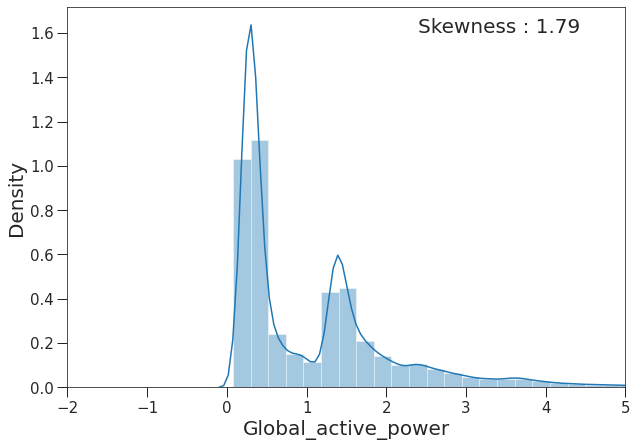

In [12]:
ax=sns.distplot(df.Global_active_power)
skewness=stats.skew(df.Global_active_power)
ax.annotate(f'Skewness : {skewness:.2f}',xy=(2.4,1.6),size=20)
plt.xlim([-2,5])

# Global Active Power Distribution

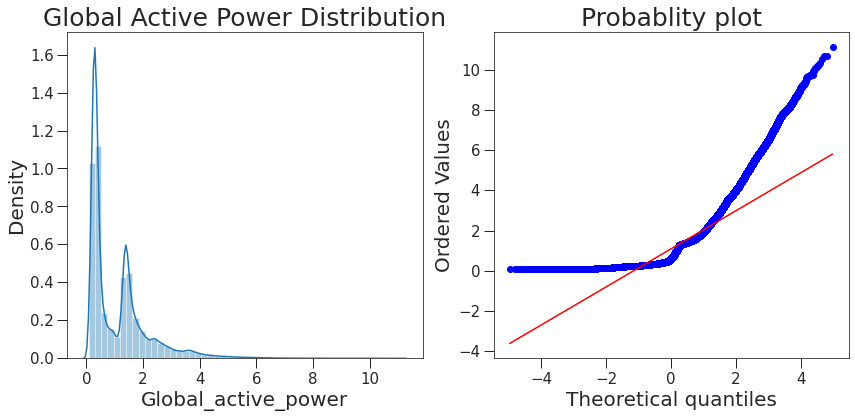

In [13]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.distplot(df['Global_active_power'])
plt.title('Global Active Power Distribution',size=25)

plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'], plot=plt)
plt.title('Probablity plot',size=25);

## Conclusion

- Shiparo-Wilk concludes that data is not sampled from a normal distribution.
- D’Agostino’s K$^2$ test also concludes that data is not sampled from a normal distribution.
- `Global_active_power` data is highly skewed because the skewness is greater than 1, which can also be confirmed from the probability plot.

# Timeseries analysis

Text(0.5, 1.0, 'Global Active Power Time Series')

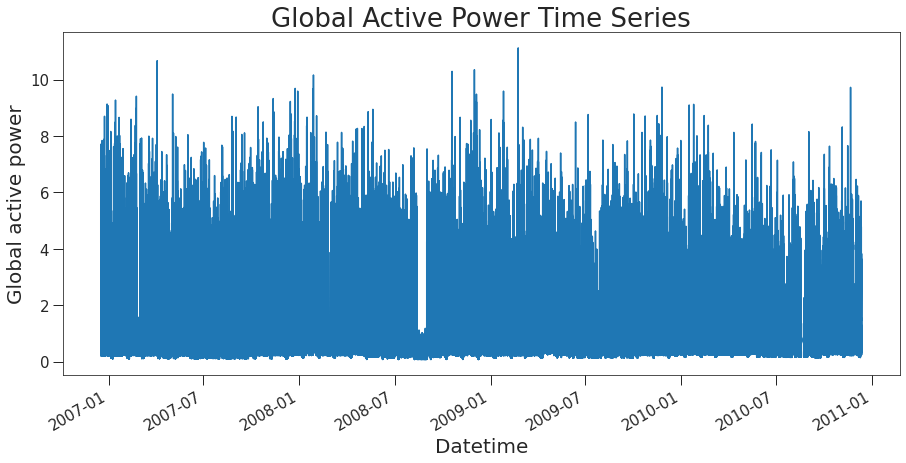

In [14]:
df['Global_active_power'].plot(figsize=(15,7),legend=False)
plt.ylabel('Global active power')
plt.title('Global Active Power Time Series',size=26)

## Global Active Power by Years

Text(0.5, 0, 'Date')

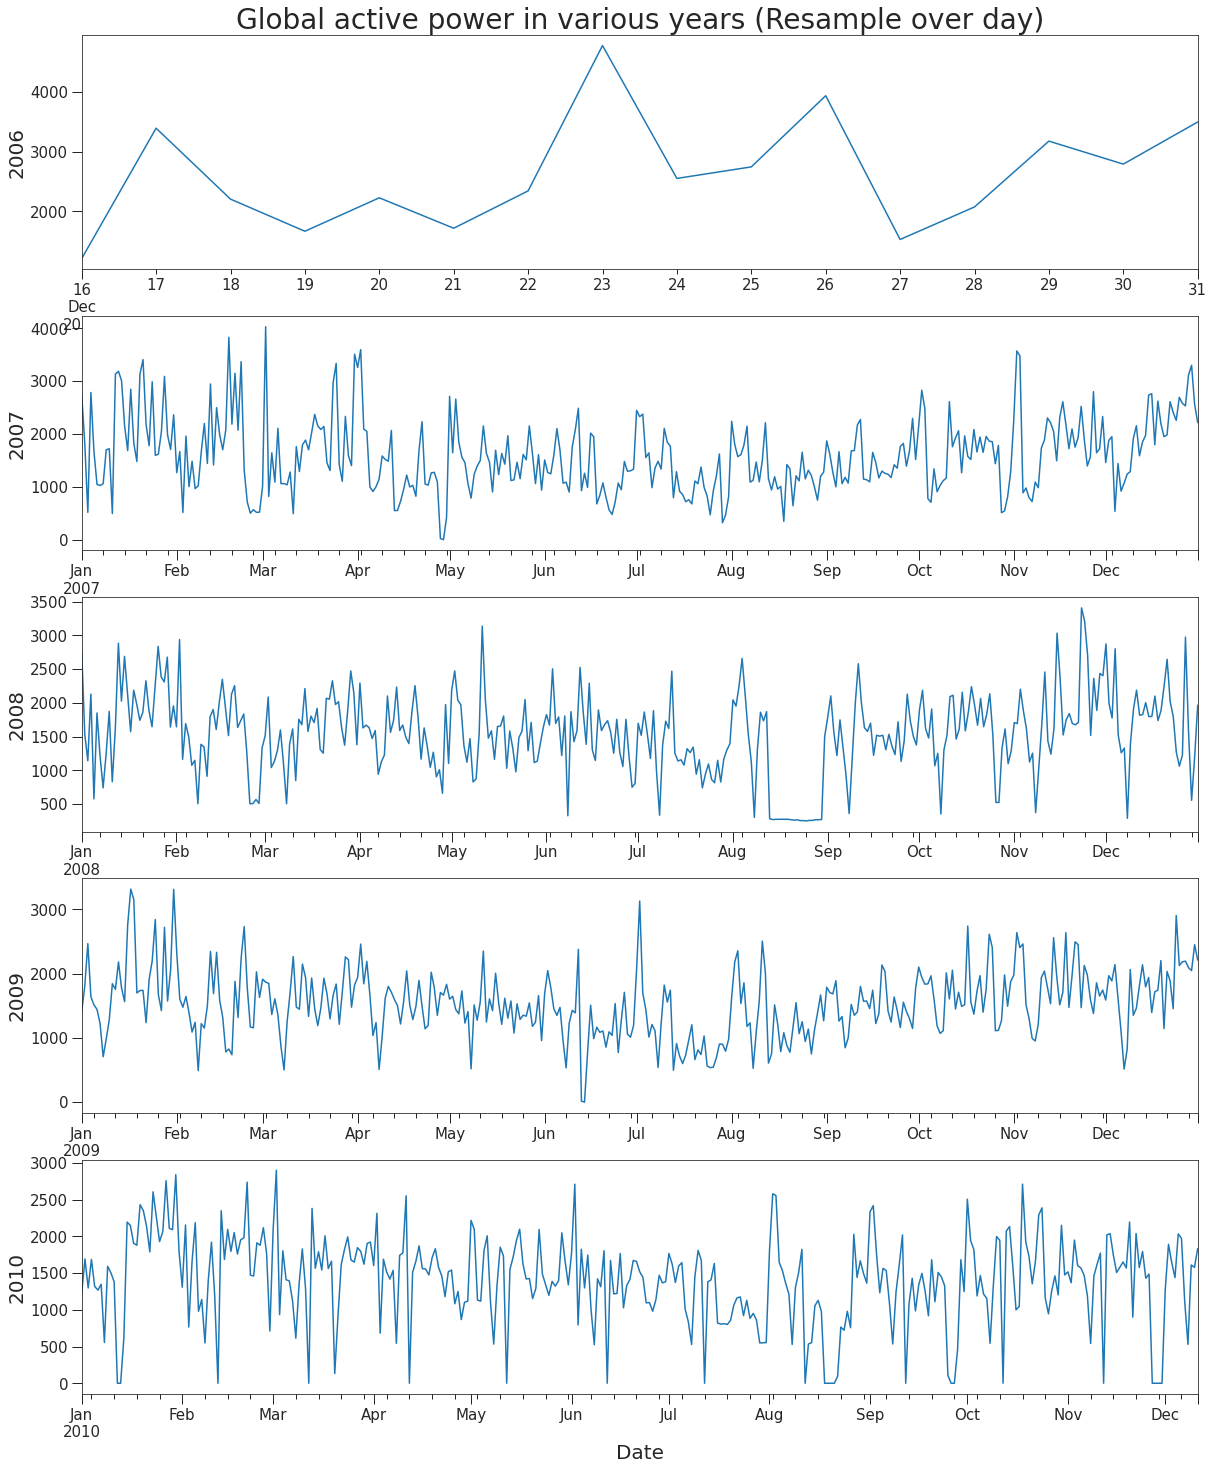

In [15]:
fig, axes = plt.subplots(ncols=1,nrows=5,figsize=(20,25))
years=df['year'].unique()
for i,ax in enumerate(axes.flat):
            df['Global_active_power'][str(years[i])].resample('D').sum().plot(ax=ax)
            ax.set_ylabel(years[i])
axes[0].set_title('Global active power in various years (Resample over day)',size=28);
plt.xlabel('Date')

For 2006, we only have data for December, so discarding 2006.

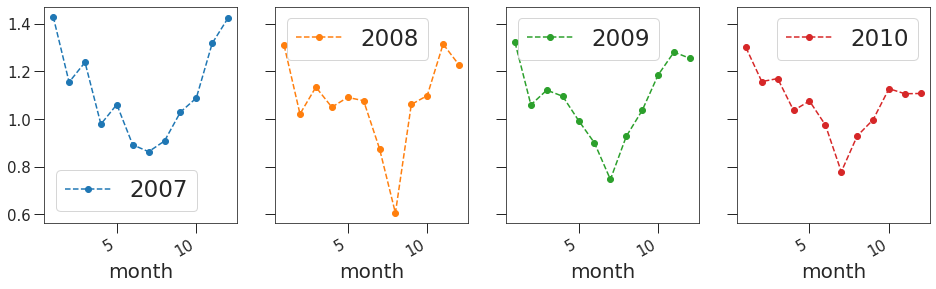

In [16]:
pd.pivot_table(df.loc[df['year'] != 2006], values = "Global_active_power", 
               columns = 'year', index = 'month').plot(
               subplots = True, figsize=(20, 15), layout=(3, 5), sharey=True, marker='o',ls='--');

## Box plot of yearly vs quarterly Global active power

Text(0.5, 1.0, 'Box plot of Quarterly Global Active Power')

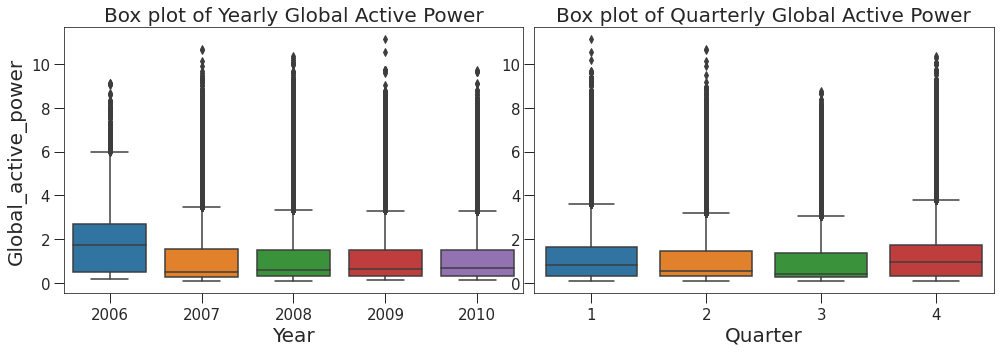

In [17]:
fig,ax= plt.subplots(figsize=(14,5),sharey=True)
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=1)
sns.boxplot(x='year', y='Global_active_power', data=df)
plt.xlabel('Year')
plt.title('Box plot of Yearly Global Active Power',size=20)
plt.tight_layout() 

plt.subplot(1,2,2)
sns.boxplot(x='quarter', y='Global_active_power', data=df)
plt.xlabel('Quarter')
plt.ylabel('')
plt.title('Box plot of Quarterly Global Active Power',size=20)


From the timeseries plots it is clear that we only have a month of data available for year 2006. Therefore, interpretation of year 2006 should be excluded from the any yearwise analysis because it can be misleading. It can be noted in the boxplots above. The median of year 2006 in left lie above the median of other years. Also, consumption is increased in quarter 4, which can be noted in the quartely boxplot.

## Violin plot of yearly vs quarterly Global active power

Text(0.5, 1.0, 'Box plot of Quarterly Global Active Power')

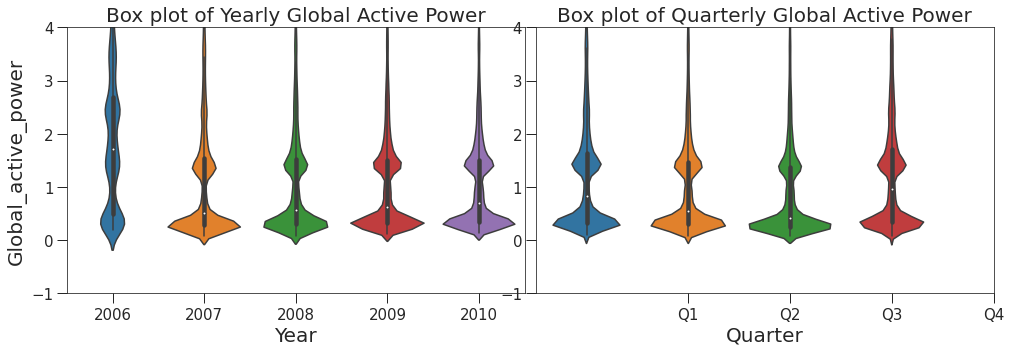

In [18]:
fig,ax= plt.subplots(figsize=(14,5),sharey=True)
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=1)
sns.violinplot(x='year', y='Global_active_power', data=df)
plt.xlabel('Year')
plt.title('Box plot of Yearly Global Active Power',size=20)
plt.ylim([-1,4])
plt.tight_layout() 

plt.subplot(1,2,2)
sns.violinplot(x='quarter', y='Global_active_power', data=df)
plt.xlabel('Quarter')
plt.ylabel('')
plt.ylim([-1,4])
plt.xticks(range(1,5),['Q1','Q2','Q3','Q4'])
plt.title('Box plot of Quarterly Global Active Power',size=20)

## Yearly distribution and Skewness

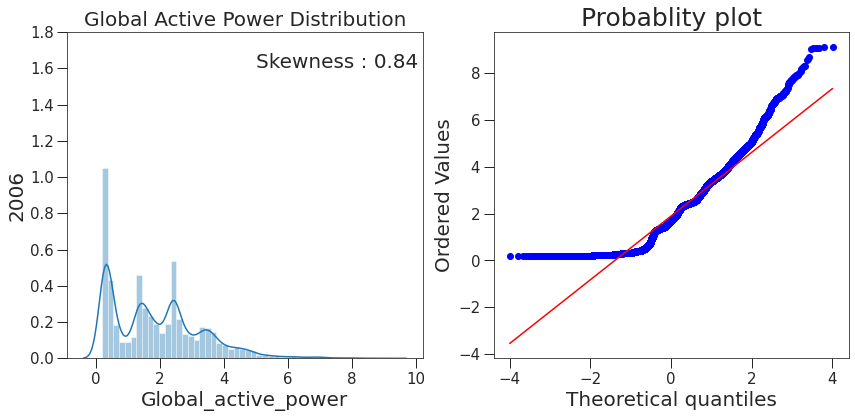

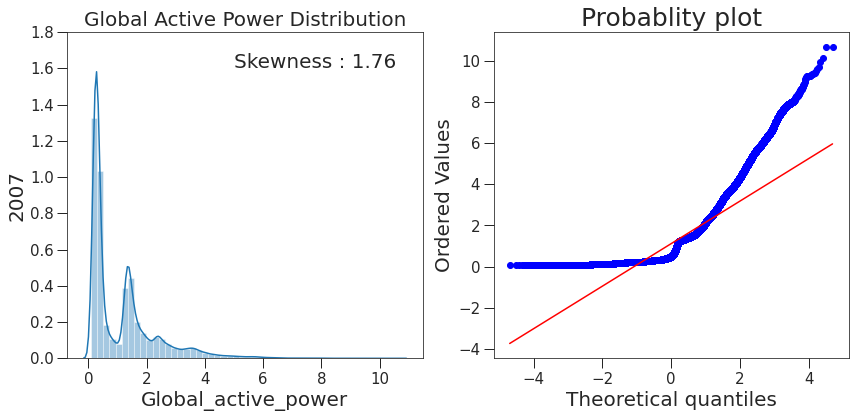

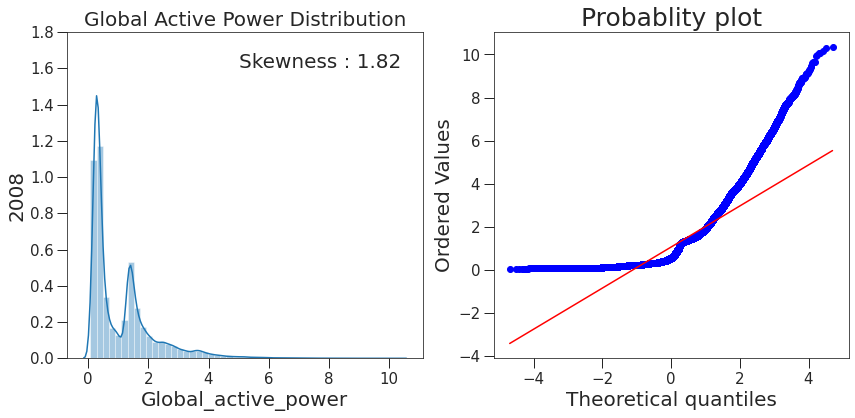

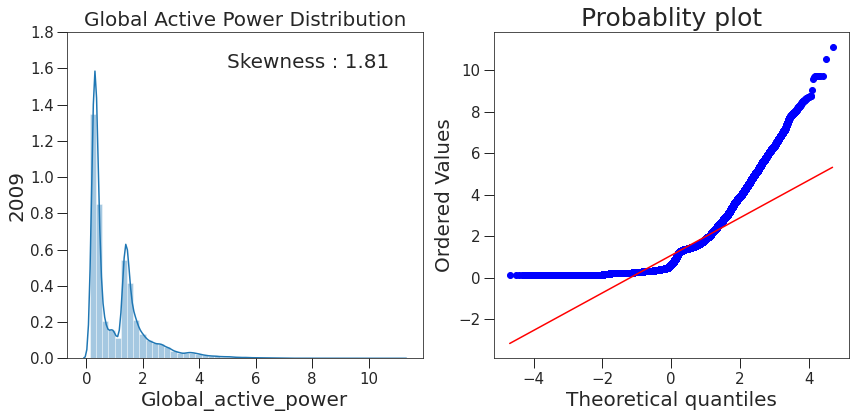

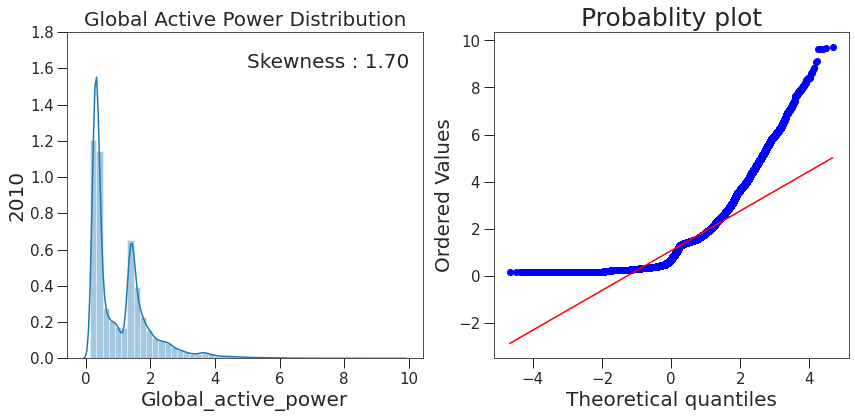

In [19]:
for year in years:
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    ax=sns.distplot(df['Global_active_power'][str(year)])
    skewness=stats.skew(df.Global_active_power[str(year)])
    ax.annotate(f'Skewness : {skewness:.2f}',xy=(5,1.6),size=20)
    plt.title('Global Active Power Distribution',size=20)
    plt.ylim([0,1.8])
    plt.ylabel(year)

    plt.subplot(1,2,2)
    stats.probplot(df['Global_active_power'][str(year)], plot=plt)
    plt.title('Probablity plot',size=25)
    plt.show()

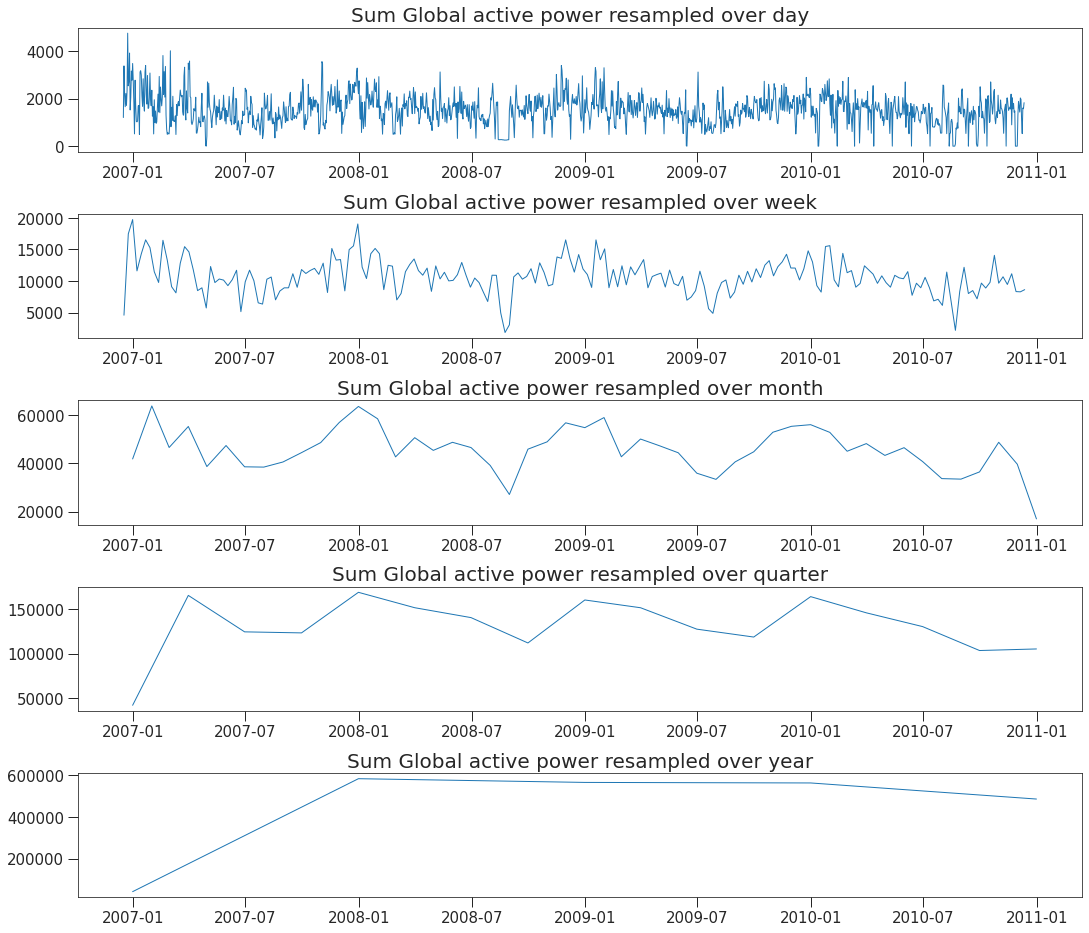

In [20]:
fig= plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df['Global_active_power'].resample('D').sum(),linewidth=1)
ax1.set_title('Sum Global active power resampled over day',size=20)
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df['Global_active_power'].resample('W').sum(),linewidth=1)
ax2.set_title('Sum Global active power resampled over week',size=20)
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df['Global_active_power'].resample('M').sum(),linewidth=1)
ax3.set_title('Sum Global active power resampled over month',size=20)
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df['Global_active_power'].resample('Q').sum(),linewidth=1)
ax4.set_title('Sum Global active power resampled over quarter',size=20)
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df['Global_active_power'].resample('A').sum(),linewidth=1)
ax5.set_title('Sum Global active power resampled over year',size=20)
ax5.tick_params(axis='both', which='major');

## Plot mean global active power grouped by year, quarter, month and day.

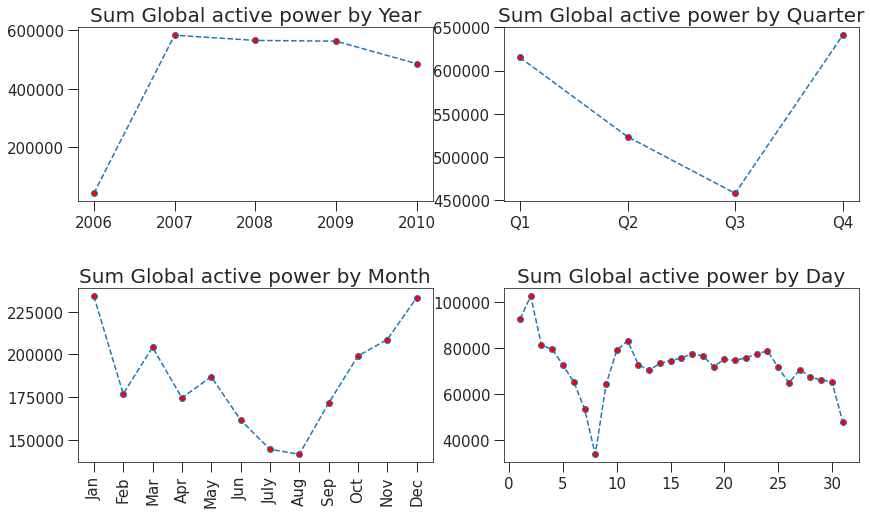

In [21]:
fig,ax=plt.subplots(figsize=(14,8))
plt.subplot(2,2,1)
fig.subplots_adjust(hspace=0.5)
df.groupby('year').Global_active_power.agg('sum').plot(marker='o',markerfacecolor='r',ls='--')
plt.xlabel('')
plt.title('Sum Global active power by Year',size=20)

plt.subplot(2,2,2)
df.groupby('quarter').Global_active_power.agg('sum').plot(marker='o', markerfacecolor='r',ls='--')
plt.xlabel('')
plt.title('Sum Global active power by Quarter',size=20)
plt.xticks(range(1,5),['Q1','Q2','Q3','Q4'])

plt.subplot(2,2,3)
df.groupby('month').Global_active_power.agg('sum').plot(marker='o',markerfacecolor='r',ls='--')
plt.xlabel('')
plt.title('Sum Global active power by Month',size=20)
plt.xticks(range(1,13),['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec'],rotation=90)

plt.subplot(2,2,4)
df.groupby('day').Global_active_power.agg('sum').plot(marker='o',markerfacecolor='r',ls='--')
plt.xlabel('')
plt.title('Sum Global active power by Day',size=20);

## Global active power consumption in Weekdays vs. Weekends

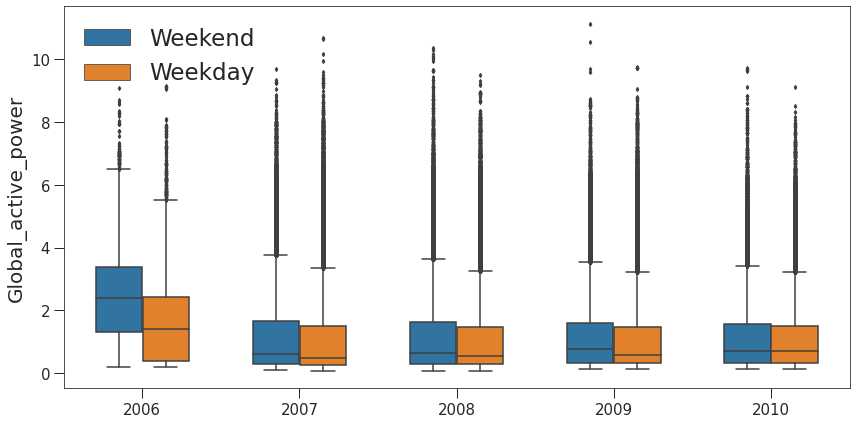

In [22]:
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
plt.figure(figsize=(12,6)) 
sns.boxplot('year','Global_active_power',hue='Day',width=0.6,fliersize=3,data=df)                                                                                                                                                                                                                                                                                                                                                 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend(frameon=False);

The median global active power in appears to be lower than the weekends prior to 2010, possibly due to subject being at work during the weekdays.

<Figure size 720x504 with 0 Axes>

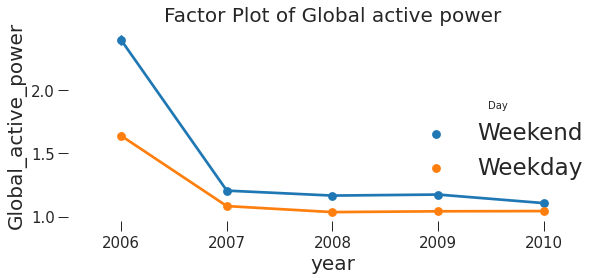

In [23]:
plt.figure(figsize=(10,7))
sns.factorplot('year','Global_active_power',hue='Day',
                    data=df, size=4, aspect=1.5,)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global active power',size=20)                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 

Both weekdays and weekends have the similar trends over year.

# Checking Stationarity in Timeseries data
In principle we do not need to check for stationarity nor correct for it when we are using an LSTM. However, if the data is stationary, it will help with better performance and make it easier for the neural network to learn.

## Dickey-Fuller test
Null Hypothesis (H$_0$): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H$_1$): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H$_0$), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H$_0$), the data does not have a unit root and is stationary.

In [24]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
  
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries,label='Original')
    mean = plt.plot(rolmean,label='Rolling Mean')
    std = plt.plot(rolstd,label = 'Rolling Std')

    plt.legend(frameon=False,prop={'size':15})
    plt.title('Rolling Mean & Standard Deviation',size=25)
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput.round(2))

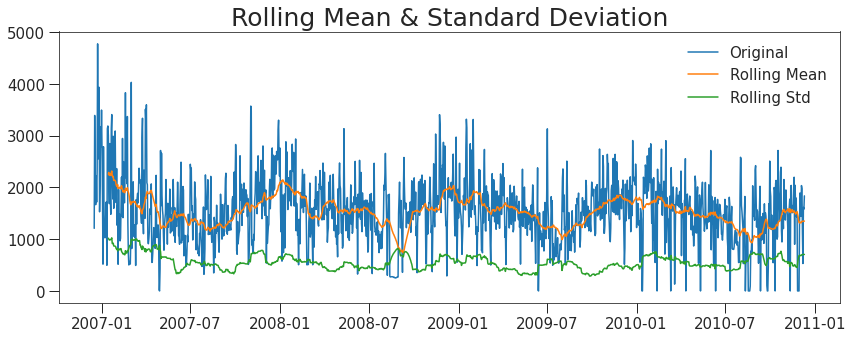

<Results of Dickey-Fuller Test>
Test Statistic                   -9.42
p-value                           0.00
#Lags Used                        7.00
Number of Observations Used    1449.00
Critical Value (1%)              -3.43
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


In [25]:
test_stationarity(df.resample('D').sum()['Global_active_power'].dropna())

From the above results, p-value is really suggesting that given the evidence the null hypothesis H$_0$ can be rejected, the data does not have a unit root and is stationary.

# Recurrent Neural Networks : LSTM
## Preprocessing for the model

In [26]:
data = df.Global_active_power.resample('10T').sum().values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [27]:
train = data[0:int(len(data) * 0.80)]
test = data[int(len(data) * 0.80) : int(len(data) * 0.90)]
valid = data[int(len(data) * 0.90) :]
print(f'train : {len(train)}\ntrain : {len(test)}\nvalidation : {len(valid)}' )

train : 167763
train : 20970
validation : 20971


## Formulating into a supervised learning problem

In [28]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [29]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
X_val, Y_val = create_dataset(valid, look_back)

In [30]:
print(f'Feature Shape{X_train.shape}\nTarget Shape{Y_train.shape}')

Feature Shape(167732, 30)
Target Shape(167732,)


In [31]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

## Model Creation

In [32]:
n_units=128
batch_size=64
n_epochs=20
patience=10

model = Sequential()
model.add(LSTM(n_units, return_sequences=True, input_shape=(X_train.shape[1:])))
model.add(Dropout(0.5))
model.add(LSTM(n_units))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', 
              metrics=['mse','mape'],
              optimizer='adam')
model.summary()


model.fit(X_train, Y_train, 
                    epochs=n_epochs, batch_size=batch_size, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[ReduceLROnPlateau(), 
                    ModelCheckpoint('LSTM-N{}-D0.5-B{}.h5'.format(n_units,batch_size)),
                    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
                    CSVLogger(f"LSTM-log-Nodes-{n_units}-dropout-0.5-batchsize-{batch_size}.csv")], 
                    verbose=1, shuffle=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            81408     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 213,121
Trainable params: 213,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2621/2621 [============================

## Forecasting with LSTM

In [33]:
model=load_model('LSTM-N128-D0.5-B64.h5')

In [34]:
val_predict = model.predict(X_val)
val_predict = scaler.inverse_transform(val_predict)
Y_val = scaler.inverse_transform(Y_val.reshape(-1,1))


print('Validation Mean Absolute Error:', mean_absolute_error(Y_val.flatten(), val_predict.flatten()))
print('Validation Root Mean Squared Error:',math.sqrt(mean_squared_error(Y_val.flatten(), val_predict.flatten())))

655/655 [==============================] - 2s 2ms/step
Validation Mean Absolute Error: 2.3473524553930423
Validation Root Mean Squared Error: 4.1452204976122795


## Convergence LSTM

In [35]:
LSTM=pd.read_csv('LSTM-log-Nodes-128-dropout-0.5-batchsize-64.csv')

(1.0, 1.8)

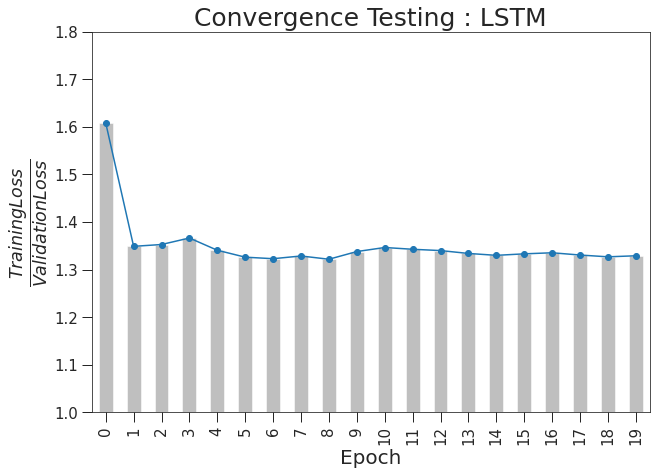

In [36]:
plt.figure(figsize=(10,7))
LSTM['Training_Loss/Validation_Loss'] = LSTM['loss']/LSTM['val_loss']
ax=LSTM['Training_Loss/Validation_Loss'].plot(x='epoch',marker='o')
LSTM['Training_Loss/Validation_Loss'].plot.bar(x='epoch',ax=ax,alpha=0.5,color='gray')
plt.ylabel(r'${\frac{Training Loss}{Validation Loss}}$',size=25)
plt.xlabel('Epoch')
plt.title('Convergence Testing : LSTM',size=25)
plt.ylim([1,1.8])

The above plot suggests that model quickly converges in less in 10 epochs and there is not improvement in the performance. Also, training loss and validation Loss are not very far from each other suggesting that there is no over/underfitting.

## Target vs Prediction on Valdiation (LSTM)

In [37]:
comparision=df.resample('10T').sum()[-len(valid)+look_back+1:] #removing the lookback to match the index
comparision['Predicted-LSTM'] = val_predict
comparision.drop(['year','quarter','month','day','weekday'],axis=1,inplace=True)
comparision.to_csv('LSTM-predicted.csv',index=True)

# Recurrent Neural Networks : GRU

In [38]:
n_units=128
batch_size=64
n_epochs=20
patience=10

model = Sequential()
model.add(GRU(n_units, return_sequences=True, input_shape=(X_train.shape[1:])))
model.add(Dropout(0.5))
model.add(GRU(n_units))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', 
              metrics=['mse','mape'],
              optimizer='adam')
model.summary()

model.fit(X_train, Y_train, 
                    epochs=n_epochs, batch_size=batch_size, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[ReduceLROnPlateau(), 
                    ModelCheckpoint('GRU-N{}-D0.5-B{}.h5'.format(n_units,batch_size)),
                    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
                    CSVLogger(f"GRU-log-Nodes-{n_units}-dropout-0.5-batchsize-{batch_size}.csv")], 
                    verbose=1, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 128)            61440     
                                                                 
 dropout_2 (Dropout)         (None, 1, 128)            0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 160,641
Trainable params: 160,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2621/2621 [==========================

## Forecasting with GRU

In [39]:
model=load_model('GRU-N128-D0.5-B64.h5')

In [40]:
val_predict = model.predict(X_val)
val_predict = scaler.inverse_transform(val_predict)
Y_val = scaler.inverse_transform(Y_val.reshape(-1,1))


print('Validation Mean Absolute Error:', mean_absolute_error(Y_val.flatten(), val_predict.flatten()))
print('Validation Root Mean Squared Error:',math.sqrt(mean_squared_error(Y_val.flatten(), val_predict.flatten())))

655/655 [==============================] - 2s 3ms/step
Validation Mean Absolute Error: 787.5799442235483
Validation Root Mean Squared Error: 1111.631351705605


## Convergence GRU

In [41]:
GRU=pd.read_csv('GRU-log-Nodes-128-dropout-0.5-batchsize-64.csv')

(1.0, 1.8)

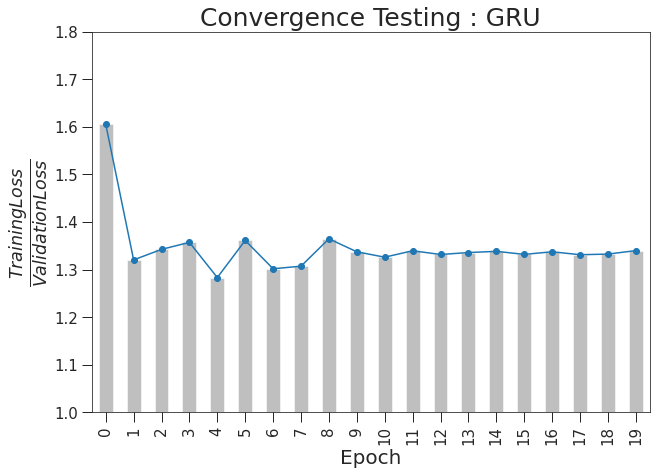

In [42]:
plt.figure(figsize=(10,7))
GRU['Training_Loss/Validation_Loss'] = GRU['loss']/GRU['val_loss']
ax=GRU['Training_Loss/Validation_Loss'].plot(x='epoch',marker='o')
GRU['Training_Loss/Validation_Loss'].plot.bar(x='epoch',ax=ax,alpha=0.5,color='gray')
plt.ylabel(r'${\frac{Training Loss}{Validation Loss}}$',size=25)
plt.xlabel('Epoch')
plt.title('Convergence Testing : GRU',size=25)
plt.ylim([1,1.8])

The above plot suggests that GRU also converges quickly. There is not improvement in the performance after 6 epochs. Also, training loss and validation Loss are not very far from each other suggesting that there is no over/underfitting.

## Target vs Prediction on Valdiation (GRU)

In [43]:
comparision=df.resample('10T').sum()[-len(valid)+look_back+1:] #removing the lookback to match the index
comparision['Predicted-GRU'] = val_predict
comparision.drop(['year','quarter','month','day','weekday'],axis=1,inplace=True)
comparision.to_csv('GRU-predicted.csv',index=True)

## Comparision : LSTM vs GRU

In [44]:
LSTM_pred = pd.read_csv('LSTM-predicted.csv',index_col=0,parse_dates=['Datetime'])
GRU_pred = pd.read_csv('GRU-predicted.csv',index_col=0,parse_dates=['Datetime'])

In [45]:
models=pd.concat([LSTM_pred['Global_active_power'], LSTM_pred['Predicted-LSTM'], GRU_pred['Predicted-GRU']],axis=1)

In [46]:
models.head(10).style.bar(axis=0)

,Global_active_power,Predicted-LSTM,Predicted-GRU
Datetime,,,
2010-07-19 14:00:00,2.928000,4.824264,4.861508
2010-07-19 14:10:00,6.298000,4.975306,5.029485
2010-07-19 14:20:00,2.866000,3.629317,3.643922
2010-07-19 14:30:00,4.178000,7.694969,7.681237
2010-07-19 14:40:00,2.932000,3.227503,3.292434
2010-07-19 14:50:00,1.580000,5.181438,5.190702
2010-07-19 15:00:00,3.766000,3.623508,3.657785
2010-07-19 15:10:00,6.882000,2.260472,2.287906
2010-07-19 15:20:00,8.860000,4.808337,4.862275


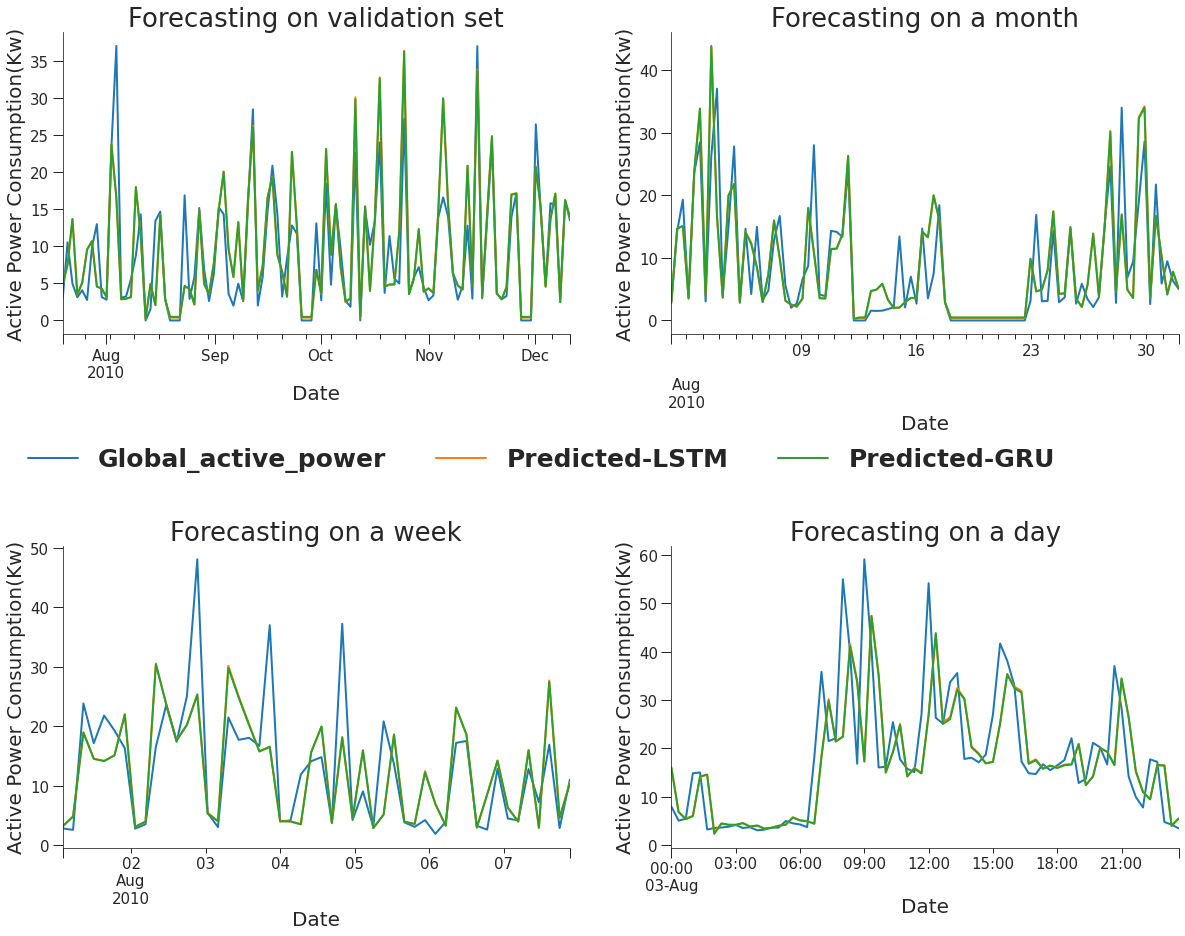

In [50]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.7)

ax=fig.add_subplot(221)
models[::200].plot(lw=2,ax=ax,legend=False)
sns.despine(top=True)
plt.ylabel('Active Power Consumption(Kw)')
plt.xlabel('Date')
plt.title('Forecasting on validation set',size=26)

ax=fig.add_subplot(222)
models[::50]['2010-08'].plot(lw=2,ax=ax)
plt.legend(frameon=False,loc='best',bbox_to_anchor=(0.8,-0.3), ncol=3,prop={'size':25, 'weight':'bold'})
sns.despine(top=True)
plt.ylabel('Active Power Consumption(Kw)')
plt.xlabel('Date')
plt.title('Forecasting on a month',size=26)


ax=fig.add_subplot(223)
models[::20]['2010-08-01':'2010-08-07'].plot(lw=2,ax=ax,legend=False)
sns.despine(top=True)
plt.ylabel('Active Power Consumption(Kw)')
plt.xlabel('Date')
plt.title('Forecasting on a week',size=26)


ax=fig.add_subplot(224)
models[::2]['2010-08-03'].plot(lw=2,ax=ax,legend=False)
sns.despine(top=True)
plt.ylabel('Active Power Consumption(Kw)')
plt.xlabel('Date')
plt.title('Forecasting on a day',size=26);
plt.savefig('Forecast.png',format='png',dpi=300)

Interestingly both models are good at forecasting the time series with very minor deviation. Hyperparameter tuning is required to improve upon current prediction.